In [1]:
#conda install -c conda-forge pymc3

In [2]:
import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import pandas as pd
from dateutil.parser import parse
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import *
import datetime

import json
from oandapyV20 import API
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
import pandas as pd
import arviz as az
import pymc3 as pm
import theano.tensor as tt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:



def get_data(granularity, instrument, save_csv=False):
    client = API(access_token="e11aadc917842adf254cd73c038c4e0a-321ea21ac5697ab46036807f5e5e943d")
    

    params = {

        "granularity": granularity,
        "count": 600,
     }
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
            rv = client.request(r)
            results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                        "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                       "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                       } for candle in r.response.get('candles')]
            df = df.append(pd.DataFrame(results), ignore_index=True)

    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
df = get_data(instrument = "XAU_AUD", granularity = "H2", save_csv=False)
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-05-10T17:00:00,2665.03,2666.044,2652.082,2654.201,31239.0
2022-05-10T19:00:00,2654.039,2654.955,2644.8,2648.939,19838.0
2022-05-10T21:00:00,2651.434,2652.914,2650.116,2650.678,2266.0
2022-05-10T23:00:00,2650.658,2651.454,2638.812,2639.722,11213.0
2022-05-11T01:00:00,2639.664,2644.055,2637.318,2642.075,11252.0


<AxesSubplot:xlabel='Date'>

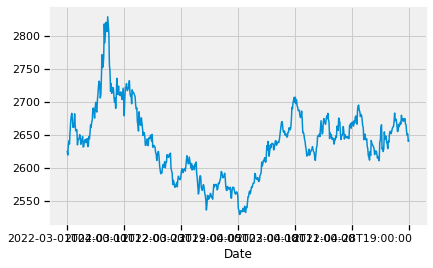

In [5]:
df['Close'].plot()

In [6]:

y2 = (df['Close'].pct_change()).values




In [7]:
log_returns = y2

In [8]:
class StochasticVolatilityProcess(pm.distributions.distribution.Continuous):
    def __init__(self, mu=None, phi=None, sigmav=None,
                 *args, **kwargs):
        super(StochasticVolatilityProcess, self).__init__(*args, **kwargs)
        self.alpha = pm.Deterministic('alpha', (1. - phi) * mu)
        self.phi = phi
        self.sigmav = sigmav
        self.init = pm.Normal.dist(mu=mu, sd=sigmav)
        self.mean = tt.as_tensor_variable(0.)

    def logp(self, x):
        alpha = self.alpha
        phi = self.phi
        sigmav = self.sigmav
        init = self.init

        x_im1 = x[:-1]
        x_i = x[1:]

        innov_like = pm.Normal.dist(mu=alpha + phi * x_im1, sd=sigmav).logp(x_i)
        return init.logp(x[0]) + tt.sum(innov_like)

    def _repr_latex_(self, name=None, dist=None):
        if dist is None:
            dist = self
        mu = dist.mu
        sd = dist.sd
        name = r'\text{%s}' % name
        return r'${} \sim \text{{StochasticVolatilityProcess}}(\mathit{{mu}}={},~\mathit{{sd}}={})$'.format(name,
                get_variable_name(mu), get_variable_name(sd))

In [9]:
# here I add the dims and the coords - first with x_shared, and later on with the observed = x in the y parameter

x1 = log_returns
dims="date"

def make_stochastic_volatility_model_with_leverage(model, x1):
    x_shared = pm.Data("x_shared", x1, dims="date", export_index_as_coords=True)
    mu = pm.Normal(name='mu', mu=0., sd=np.sqrt(25.))
    phistar = pm.Beta(name='phistar', alpha=20., beta=1.5)
    recsigmav2 = pm.Gamma(name='recsigmav2', alpha=2.5, beta=.25)
    beta = pm.math.exp(pm.Deterministic('beta', .5 * mu))
    phi = pm.Deterministic('phi', 2. * phistar - 1.)
    sigmav = pm.Deterministic('sigmav', pm.math.sqrt(1. / recsigmav2))
    rho = pm.Uniform(name='rho', lower=-1., upper=1.)
    x = StochasticVolatilityProcess('x', mu, phi, sigmav, shape=len(log_returns) + 2)
    y = pm.Normal(name='y',
                  mu=rho / sigmav * pm.math.exp(.5 * x[1:-1]) * (x[2:] - (1. - phi) * mu - phi * x[1:-1]),
                  sd=pm.math.sqrt(pm.math.exp(x[1:-1]) * (1 - rho * rho)),
                  observed=x1, dims='date')

Making model...
Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [y_missing, x, rho, recsigmav2, phistar, mu]


Sampling 1 chain for 500 tune and 5_000 draw iterations (500 + 5_000 draws total) took 246 seconds.
The acceptance probability does not match the target. It is 0.8611493500109635, but should be close to 0.95. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


0, dim: date, 600 =? 600
Producing trace plot...
0, dim: date, 600 =? 600
0, dim: date, 600 =? 600


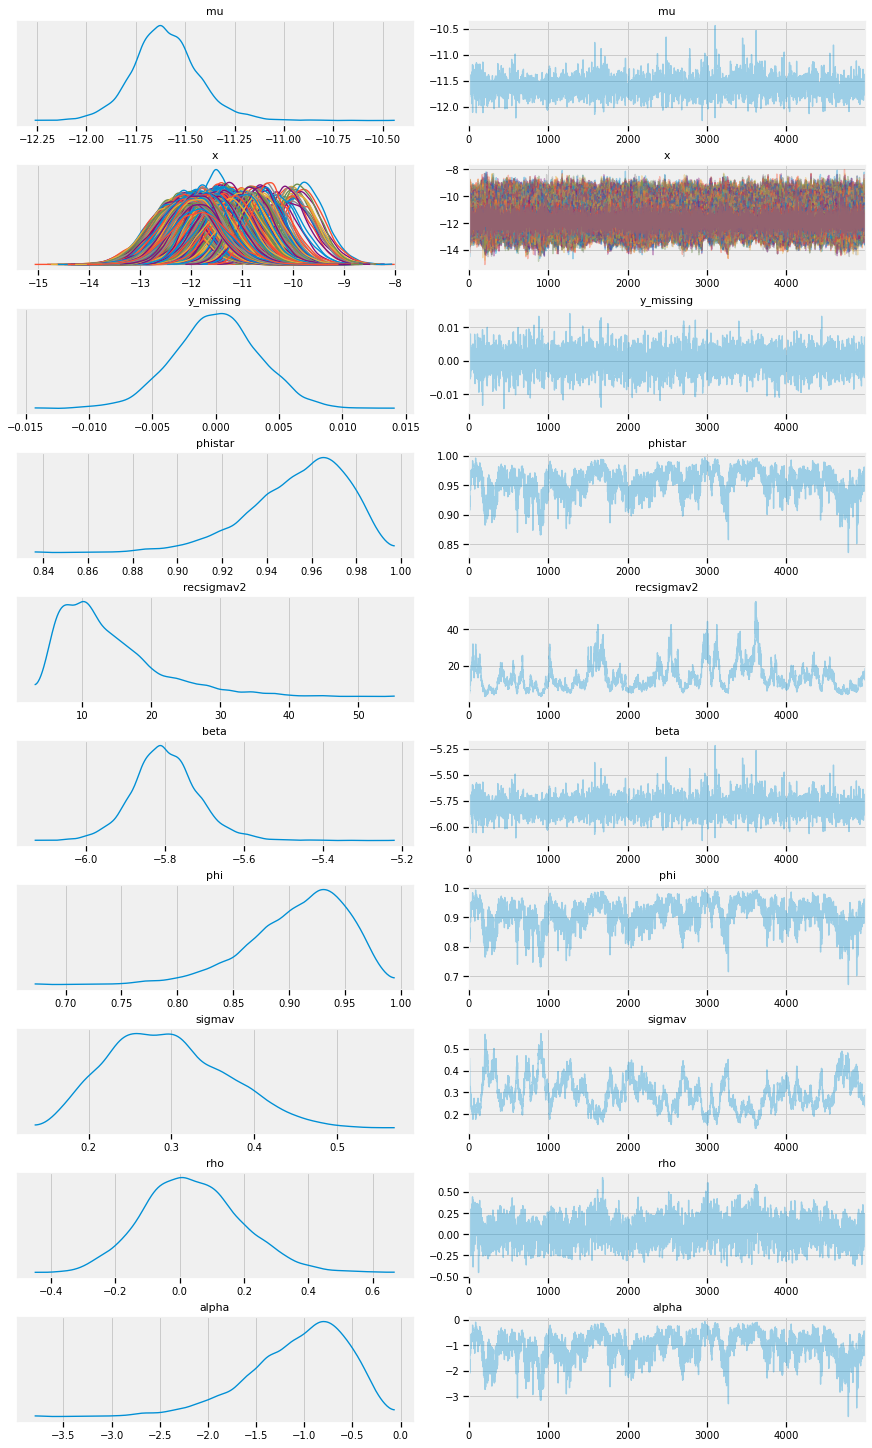

In [10]:


with pm.Model() as model:
    print('Making model...')
    make_stochastic_volatility_model_with_leverage(model, x1)
    print('Sampling...')
    trace = pm.sample(tune=500, draws=5000, target_accept = .95,  chains=1)
    print('Producing trace plot...')
    pm.traceplot(trace);



In [11]:
pm.summary((trace), hdi_prob=0.95)

0, dim: date, 600 =? 600


arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-11.599,0.171,-11.933,-11.253,0.006,0.004,1062.0,1376.0,NaN
x[0],-11.512,0.332,-12.145,-10.852,0.005,0.003,4867.0,2802.0,NaN
x[1],-11.431,0.390,-12.209,-10.678,0.005,0.004,5522.0,2935.0,NaN
x[2],-11.343,0.407,-12.163,-10.531,0.005,0.004,6019.0,3675.0,NaN
x[3],-11.242,0.404,-12.061,-10.463,0.007,0.005,4199.0,2397.0,NaN
...,...,...,...,...,...,...,...,...,...
beta,-5.799,0.086,-5.966,-5.627,0.003,0.002,1062.0,1376.0,NaN
phi,0.909,0.044,0.821,0.982,0.006,0.005,43.0,166.0,NaN
sigmav,0.296,0.072,0.162,0.430,0.012,0.009,33.0,114.0,NaN
rho,0.040,0.151,-0.261,0.327,0.011,0.008,208.0,244.0,NaN


0, dim: date, 600 =? 600


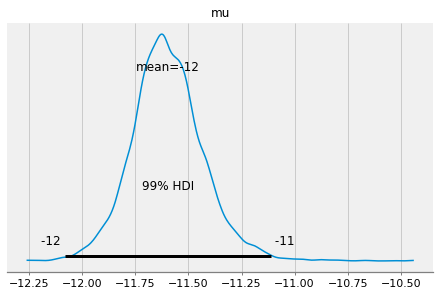

In [12]:
# it seems the posterior can be used .... in a way for estimation ....

az.plot_posterior(
    trace, var_names=["mu"],  hdi_prob=0.99
);

In [13]:
# I set a variable for the lenght of the dims and add the forecast period I want .... 
length = len(dims) + 10

In [27]:
# here I run the model for the new lenght and for the variable = mu 
posterior_pred = pm.sample_posterior_predictive(trace, length, var_names=['mu', 'beta', 'sigmav', 'alpha'], model= model)
posterior_pred

{'mu': array([-11.74126732, -11.66655469, -11.79427513, -11.5514726 ,
        -11.81936554, -11.51148426, -11.81064914, -11.47234003,
        -11.38388539, -11.69715991, -11.46415799, -11.67669251,
        -11.46527457, -11.75734468]),
 'beta': array([-5.87063366, -5.83327735, -5.89713757, -5.7757363 , -5.90968277,
        -5.75574213, -5.90532457, -5.73617002, -5.6919427 , -5.84857996,
        -5.73207899, -5.83834625, -5.73263728, -5.87867234]),
 'sigmav': array([0.49940197, 0.52340422, 0.46339781, 0.44913402, 0.45405341,
        0.45761065, 0.45368819, 0.43562905, 0.39342656, 0.40362689,
        0.38304845, 0.3347051 , 0.31042376, 0.30237772]),
 'alpha': array([-2.32356158, -2.07040815, -1.95586984, -2.1583775 , -1.8395951 ,
        -1.64926565, -2.0335703 , -1.54289065, -2.09608489, -1.69726905,
        -1.62401635, -1.36989009, -1.15416844, -1.3732374 ])}

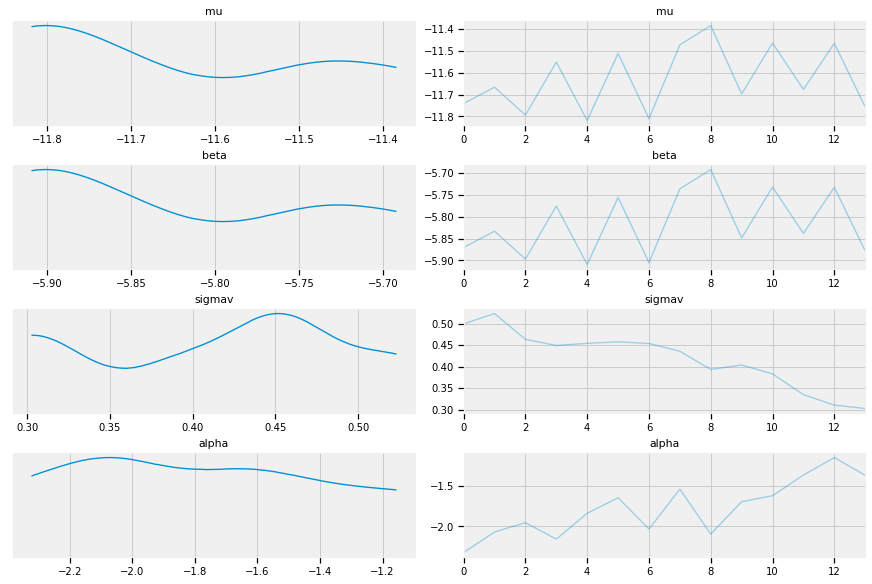

In [28]:
# after the trace was run the new mu is heading in the direction of around - 10 - so the current downtrend continous :-D
# I just wonder why the output is for 12 values and not for 10 like it was set in length .... 
import arviz as az
az.plot_trace(posterior_pred);

In [29]:
pm.summary((posterior_pred), hdi_prob=0.95)

arviz - WARNING - Shape validation failed: input_shape: (1, 14), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-11.629,0.150,-11.819,-11.384,0.063,0.047,5.0,16.0,NaN
beta,-5.815,0.075,-5.910,-5.692,0.031,0.023,5.0,16.0,NaN
sigmav,0.419,0.067,0.302,0.523,0.046,0.038,2.0,15.0,NaN
alpha,-1.778,0.345,-2.324,-1.154,0.205,0.164,3.0,15.0,NaN
